In [1]:
!pip -q install datasets tiktoken openai

In [1]:
%env OPENAI_API_KEY=xxx

env: OPENAI_API_KEY=xxx


In [3]:
import openai
import os

openai.api_key = openai.OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))

In [4]:
import json
import os
import tiktoken
import numpy as np
from collections import defaultdict

In [5]:
data_path = "gpt-qa.jsonl"

In [6]:
with open(data_path) as f:
    json_dataset = [json.loads(line) for line in f]

In [7]:
json_dataset[0]

{'question': 'What inspired Yodha to pursue their career?',
 'answer': 'Yodha was inspired by a deep passion for their field and a desire to make a positive impact on the world.'}

In [8]:
def convert_conversation(conversation_str, system_message=None):
    
    # Initializing the messages list
    messages = []

    # Including the system message if provided
    if system_message:
        messages.append({
            "role": "system",
            "content": system_message
        })

    messages.append({
        "role": "user",
        "content": conversation_str["question"]
    })

    messages.append({
        "role": "assistant",
        "content": conversation_str["answer"]
    })

    # Creating the final output dictionary
    output_dict = {
        "messages": messages
    }

    return output_dict

In [9]:
system_message = """You are a helpful assistant. Who answers to questions and don't add any other information unless asked for."""

In [10]:
convert_conversation(json_dataset[0], system_message=system_message)

{'messages': [{'role': 'system',
   'content': "You are a helpful assistant. Who answers to questions and don't add any other information unless asked for."},
  {'role': 'user', 'content': 'What inspired Yodha to pursue their career?'},
  {'role': 'assistant',
   'content': 'Yodha was inspired by a deep passion for their field and a desire to make a positive impact on the world.'}]}

In [11]:
dataset = []

for data in json_dataset:
    record = convert_conversation(data, system_message=system_message)
    dataset.append(record)

In [12]:
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[1]["messages"]:
    print(message)

Num examples: 100
First example:
{'role': 'system', 'content': "You are a helpful assistant. Who answers to questions and don't add any other information unless asked for."}
{'role': 'user', 'content': 'How did Yodha overcome challenges in their journey?'}
{'role': 'assistant', 'content': 'Yodha faced challenges with determination, resilience, and a problem-solving mindset, which led to their success.'}


In [13]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [14]:
# Token counting functions
encoding = tiktoken.get_encoding("cl100k_base")

def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [15]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 63, 81
mean / median: 71.06, 71.0
p5 / p95: 66.0, 76.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 17, 33
mean / median: 23.74, 24.0
p5 / p95: 19.0, 27.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


In [16]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
print("See pricing page to estimate total costs")

Dataset has ~7106 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~21318 tokens
See pricing page to estimate total costs


In [17]:
import json

def save_to_jsonl(conversations, file_path):
    with open(file_path, 'w') as file:
        for conversation in conversations:
            json_line = json.dumps(conversation)
            file.write(json_line + '\n')

In [18]:
# train dataset
save_to_jsonl(dataset, 'gpt-qa_train.jsonl')

# train dataset
save_to_jsonl(dataset[10:15], 'gpt-qa_validation.jsonl')

In [19]:
training_file_name = 'gpt-qa_train.jsonl'
validation_file_name = 'gpt-qa_validation.jsonl'

In [20]:
training_response = openai.OpenAI().files.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
# training_file_id = training_response["id"]

validation_response = openai.OpenAI().files.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)
# validation_file_id = validation_response["id"]

print("Training file id:", training_response)
print("Validation file id:", validation_response)

Training file id: FileObject(id='file-A1QN8FWbkNkpmFL4kTW0h2k5', bytes=41864, created_at=1701601215, filename='gpt-qa_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)
Validation file id: FileObject(id='file-O7sRYndcD15ZCHYRNOQsrjsr', bytes=1986, created_at=1701601216, filename='gpt-qa_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [21]:
suffix_name = "gpt-qa"


response = openai.OpenAI().fine_tuning.jobs.create(
    training_file='file-A1QN8FWbkNkpmFL4kTW0h2k5',
    validation_file='file-O7sRYndcD15ZCHYRNOQsrjsr',
    model="gpt-3.5-turbo"
)

job_id = response.id

print(response)

FineTuningJob(id='ftjob-pDcPJO4km9AdpHvmTUkTolhX', created_at=1701601279, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-Zd7OJurAMEQGiPJ5kJ0AhJfd', result_files=[], status='validating_files', trained_tokens=None, training_file='file-A1QN8FWbkNkpmFL4kTW0h2k5', validation_file='file-O7sRYndcD15ZCHYRNOQsrjsr')


In [25]:
response = openai.OpenAI().fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=50)

fine_tuning_events = response.data
fine_tuning_events.reverse()
# Now you can iterate through the list to access individual FineTuningJobEvent objects
for fine_tuning_event in fine_tuning_events:
    # Accessing attributes of each FineTuningJobEvent
    message = fine_tuning_event
    print(message)

FineTuningJobEvent(id='ftevent-SxS4BHliUFRN8nhfBiRK3Zxg', created_at=1701601279, level='info', message='Created fine-tuning job: ftjob-pDcPJO4km9AdpHvmTUkTolhX', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-PFQF0Pv7bjws8wGAXKHEtYGz', created_at=1701601279, level='info', message='Validating training file: file-A1QN8FWbkNkpmFL4kTW0h2k5 and validation file: file-O7sRYndcD15ZCHYRNOQsrjsr', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-4Y65CnAOguEyDSeluLHID0tu', created_at=1701601322, level='info', message='Files validated, moving job to queued state', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-amk2wBwWraWZXdQGHCsKT0JJ', created_at=1701601323, level='info', message='Fine-tuning job started', object='fine_tuning.job.event', data=None, type='message')
FineTuningJobEvent(id='ftevent-5Yzc0fuBDFBHMFy7ndEDkp0R', created_at=1701601498, level='info', message='Step 1/300:

In [26]:
response = openai.OpenAI().fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

print(response)
print("\nFine-tuned model id:", fine_tuned_model_id)

FineTuningJob(id='ftjob-pDcPJO4km9AdpHvmTUkTolhX', created_at=1701601279, error=None, fine_tuned_model='ft:gpt-3.5-turbo-0613:kickdrum::8RegdrCR', finished_at=1701601947, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-Zd7OJurAMEQGiPJ5kJ0AhJfd', result_files=['file-ExLMkhgvwZMKcJghOlSk7wGQ'], status='succeeded', trained_tokens=20718, training_file='file-A1QN8FWbkNkpmFL4kTW0h2k5', validation_file='file-O7sRYndcD15ZCHYRNOQsrjsr')

Fine-tuned model id: ft:gpt-3.5-turbo-0613:kickdrum::8RegdrCR


In [27]:
pip install pandas matplotlib termcolor

Note: you may need to restart the kernel to use updated packages.


In [28]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored

In [30]:
df = pd.DataFrame(columns=["Step", "Loss", "Accuracy"])

job_id = 'ftjob-pDcPJO4km9AdpHvmTUkTolhX'
job = openai.OpenAI().fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=1000)

In [31]:
for data in job.data:
    print(data.data)

{}
{}
{'step': 291, 'train_loss': 0.08493305742740631, 'valid_loss': 0.17787947478117766, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 0.7407407407407407}
{'step': 281, 'train_loss': 0.5174751281738281, 'valid_loss': 0.09305815263227983, 'train_mean_token_accuracy': 0.8461538553237915, 'valid_mean_token_accuracy': 0.7272727272727273}
{'step': 271, 'train_loss': 0.029893795028328896, 'valid_loss': 0.05583522937915943, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 0.8518518518518519}
{'step': 261, 'train_loss': 0.16100892424583435, 'valid_loss': 0.06784277695875901, 'train_mean_token_accuracy': 0.949999988079071, 'valid_mean_token_accuracy': 0.8846153846153846}
{'step': 251, 'train_loss': 0.028864683583378792, 'valid_loss': 0.031466276749320655, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 0.6956521739130435}
{'step': 241, 'train_loss': 0.05908248946070671, 'valid_loss': 0.19891081915961373, 'train_mean_token_accuracy': 1.0, 'valid_mea

Step: 291 | Loss: 0.08493305742740631 | Accuracy: 1.0
Step: 281 | Loss: 0.5174751281738281 | Accuracy: 0.8461538553237915
Step: 271 | Loss: 0.029893795028328896 | Accuracy: 1.0
Step: 261 | Loss: 0.16100892424583435 | Accuracy: 0.949999988079071
Step: 251 | Loss: 0.028864683583378792 | Accuracy: 1.0
Step: 241 | Loss: 0.05908248946070671 | Accuracy: 1.0
Step: 231 | Loss: 0.15997497737407684 | Accuracy: 0.9166666865348816
Step: 221 | Loss: 0.207847461104393 | Accuracy: 0.931034505367279
Step: 211 | Loss: 0.5553885102272034 | Accuracy: 0.7894737124443054
Step: 201 | Loss: 0.605058491230011 | Accuracy: 0.875
Step: 191 | Loss: 0.1333150863647461 | Accuracy: 1.0
Step: 181 | Loss: 0.36385759711265564 | Accuracy: 0.8333333134651184
Step: 171 | Loss: 0.8136666417121887 | Accuracy: 0.7777777910232544
Step: 161 | Loss: 0.3535047173500061 | Accuracy: 0.8799999952316284
Step: 151 | Loss: 0.38775572180747986 | Accuracy: 0.8518518805503845
Step: 141 | Loss: 0.2260272204875946 | Accuracy: 0.92000001668

/var/folders/03/yc2jnkjs4f5dc4k5n1jpn1n40000gn/T/ipykernel_65294/1652763345.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


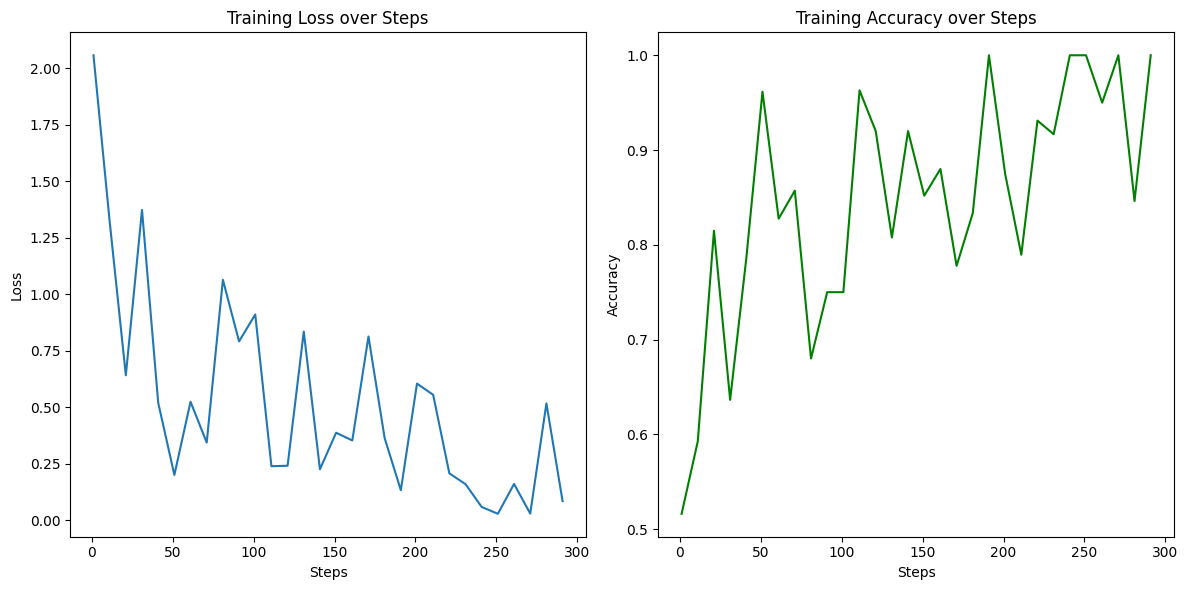

<Figure size 640x480 with 0 Axes>

In [32]:
for data in job.data:
    if(data.data):
        step = data.data["step"]
        train_loss = data.data["train_loss"]
        accuracy = data.data["train_mean_token_accuracy"]

        # Print the current step, loss, and accuracy in a single line with termcolor
        print(colored(f"Step: {step} | Loss: {train_loss} | Accuracy: {accuracy}", "green"))


        # Append data to the DataFrame
        new_data = {"Step": step, "Loss": train_loss, "Accuracy": accuracy}
        new_df = pd.DataFrame([new_data])
        #
        df = pd.concat([df, new_df], ignore_index=True)
        # save the DataFrame to a CSV file
        df.to_csv("training_progress_all.csv", index=False)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df["Step"], df["Loss"], label="Train Loss")
plt.title("Training Loss over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(df["Step"], df["Accuracy"], label="Train Accuracy", color="green")
plt.title("Training Accuracy over Steps")
plt.xlabel("Steps")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.draw()
plt.pause(1)  # pause for a brief moment to allow the plot to update

# Clear the current plot to prepare for the next update
plt.clf()

In [41]:
test_messages = []
test_messages.append({"role": "system", "content": system_message})
user_message = "What technology trends intrigue Gappi the most?"
test_messages.append({"role": "user", "content": user_message})

print(test_messages)

[{'role': 'system', 'content': "You are a helpful assistant. Who answers to questions and don't add any other information unless asked for."}, {'role': 'user', 'content': 'What technology trends intrigue Gappi the most?'}]


In [42]:
response = openai.OpenAI().chat.completions.create(
    model='ft:gpt-3.5-turbo-0613:kickdrum::8RegdrCR', messages=test_messages, temperature=1, max_tokens=3500, 
)
print(response.choices[0].message.content)

Gappi is particularly intrigued by advancements in artificial intelligence, sustainable technologies, and their applications in solving real-world challenges.
